# AI Bootcamp Project

---

**Import Libraries**

In [177]:
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer

#for models:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
from sklearn.neural_network import MLPRegressor

**Importing The Dataset**

In [178]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("likithagedipudi/linkedin-compatibility-dataset-50k-profiles")

print("Path to dataset files:", path)
#from google.colab import drive
#drive.mount('/content/drive')

Using Colab cache for faster access to the 'linkedin-compatibility-dataset-50k-profiles' dataset.
Path to dataset files: /kaggle/input/linkedin-compatibility-dataset-50k-profiles


In [179]:
#joining path with the specific filenames in the dataset
profiles_path = os.path.join(path, "profiles.csv")
pairs_path = os.path.join(path, "compatibility_pairs.csv")

#Load the data
profiles = pd.read_csv(profiles_path)
pairs = pd.read_csv(pairs_path)

print("Datasets loaded sucessfully from Kaggle!")

Datasets loaded sucessfully from Kaggle!


In [180]:
#import pandas as pd

#profiles = pd.read_csv(
 #   '/content/drive/MyDrive/ML_LinkedIn_project/profiles.csv'
#)

#pairs = pd.read_csv(
 #   '/content/drive/MyDrive/ML_LinkedIn_project/compatibility_pairs.csv'
#)

#print(profiles.shape)
#print(pairs.shape)


**Check If Data Is Loaded**

In [181]:
print("Profiles:")
print(profiles.head())
print(profiles.shape)

print("\nPairs:")
print(pairs.head())
print(pairs.shape)

print("Data is loaded sucessfully!")

Profiles:
                         profile_id           name                      email  \
0  ab04b973af478550ddf247879393df42   Daniel Doyle    garzaanthonyexample.org   
1  b620e3fa2ec361b1d728115eeabb71af  Jennifer Cole          lisa02example.net   
2  cfeeb31581a0b3e0515c01691b9dc2b5   Brent Abbott       lindsay78example.org   
3  5d54826665a5898662661a96719cc4a7    Corey Jones  kendragallowayexample.org   
4  6ad3c64c6cb4bac60b692f3d5bab271d   Timothy Wong   amandasanchezexample.com   

               location                                           headline  \
0      East William, AK     Analyst  Product  Building impactful solutions   
1      Petersonberg, IL  Senior Engineer  Design  Building impactful so...   
2        Millerport, MP  Software Engineer  Product  Building impactful...   
3  South Joshuastad, GA  Chief Data Officer  Tech  Building impactful s...   
4        Nelsonside, IN   Consultant  Design  Building impactful solutions   

                                  

**Pre-Merge Cleaning**

In [182]:
#Drop unnecessary columns from profiles
cols_to_keep_pro = ['profile_id', 'industry', 'years_experience', 'seniority_level', 'location', 'skills']
profiles = profiles[cols_to_keep_pro].copy()

#Drop unnecessary columns from compatibilities
cols_to_keep_comp = ['profile_a_id', 'profile_b_id', 'skill_match_score', 'career_alignment_score', 'experience_gap', 'seniority_match', 'compatibility_score']
pairs = pairs[cols_to_keep_comp].copy()

print("Columns selected!")

Columns selected!


In [183]:
#Handlle nulls
#Fill years of experience with median
profiles['years_experience'] = profiles['years_experience'].fillna(profiles['years_experience'].median())

#Standarize Text
profiles['industry'] = profiles['industry'].str.lower().str.strip()
profiles['location'] = profiles['location'].str.lower().str.strip()

print("Profiles cleaned! Shape: ", profiles.shape)

Profiles cleaned! Shape:  (50000, 6)


In [184]:
#Check for missing values in pairs
print("Missing values in pairs:")
print(pairs.isnull().sum())

#check if there are any nulls in the target
pairs = pairs.dropna(subset=['compatibility_score'])

print("Pairs cleaned! Shape: ", pairs.shape)

Missing values in pairs:
profile_a_id              0
profile_b_id              0
skill_match_score         0
career_alignment_score    0
experience_gap            0
seniority_match           0
compatibility_score       0
dtype: int64
Pairs cleaned! Shape:  (4999890, 7)


**The Merging Phase**

In [185]:
#Merge for profile A
#connect profile_a_id from pairs to profile_id from profiles
df_merged = pairs.merge(profiles, left_on='profile_a_id', right_on='profile_id')

#Merge for profile B
#suffixes _A and _B automatically differentiate the columns
df_final_pairs = df_merged.merge(profiles, left_on='profile_b_id', right_on='profile_id', suffixes=('_A','_B'))

#Clean: drop the extra ID columns created during merge
df_final_pairs = df_final_pairs.drop(columns=['profile_id_A', 'profile_id_B'])

print("Double Merge Successful! Shape:", df_final_pairs.shape)
print("Columns available now:", df_final_pairs.columns.tolist())

Double Merge Successful! Shape: (4999890, 17)
Columns available now: ['profile_a_id', 'profile_b_id', 'skill_match_score', 'career_alignment_score', 'experience_gap', 'seniority_match', 'compatibility_score', 'industry_A', 'years_experience_A', 'seniority_level_A', 'location_A', 'skills_A', 'industry_B', 'years_experience_B', 'seniority_level_B', 'location_B', 'skills_B']


**Post-Merging Phase**

In [186]:
#Drop rows where profiles are missing
#to be sure that no missing pro; bcz sometimes a profile exists in pairs list but missing from profile's table
df_final_pairs = df_final_pairs.dropna()

#Binary match features
#add new column 'same_industry' to check if A and B are in the same industry & location
df_final_pairs['same_industry'] = (df_final_pairs['industry_A'] == df_final_pairs['industry_B']).astype(int)
df_final_pairs['same_location'] = (df_final_pairs['location_A'] == df_final_pairs['location_B']).astype(int)

#Visulaize the current dataset columns
# print(df_final_pairs.shape)
# print(df_final_pairs.columns.tolist())

#Eliminate categorical column (location and industry)
df_final_pairs = df_final_pairs.drop(columns=['industry_A', 'industry_B', 'location_A', 'location_B'])

print("Final column's number:", df_final_pairs.shape)
print("Final columns:", df_final_pairs.columns.tolist())


Final column's number: (4999890, 15)
Final columns: ['profile_a_id', 'profile_b_id', 'skill_match_score', 'career_alignment_score', 'experience_gap', 'seniority_match', 'compatibility_score', 'years_experience_A', 'seniority_level_A', 'skills_A', 'years_experience_B', 'seniority_level_B', 'skills_B', 'same_industry', 'same_location']


In [187]:
print(df_final_pairs.head())
#Vecto

                       profile_a_id                      profile_b_id  \
0  ab04b973af478550ddf247879393df42  fdf3243d1ad97255e0ce313aebc0be79   
1  ab04b973af478550ddf247879393df42  371bc2adbdc4ca8f0dd16d373f85f2ae   
2  ab04b973af478550ddf247879393df42  d18e7cd91fc4e621fd6879ca5ef6e1b2   
3  ab04b973af478550ddf247879393df42  6615dabdd3b5b8f9627ca933dc3d9ae3   
4  ab04b973af478550ddf247879393df42  fc73d0e790dea954d20db176f638ab86   

   skill_match_score  career_alignment_score  experience_gap  seniority_match  \
0           0.000000                    80.0               0             85.0   
1           5.555556                    80.0               2            100.0   
2           5.555556                    80.0               2            100.0   
3           8.000000                    40.0              27             50.0   
4           7.142857                    90.0               5            100.0   

   compatibility_score  years_experience_A seniority_level_A  \
0         

In [188]:
#Skill overlapp calculation
#turning the list of skills into nums to represent how many they share
def calculate_overlap(row):
  #find common skills using set instruction
  set_a = set(str(row['skills_A']).lower().replace('[','').replace(']','').split(','))
  set_b = set(str(row['skills_B']).lower().replace('[','').replace(']','').split(','))
  return len(set_a.intersection(set_b))

df_final_pairs['skills_overlap_count'] = df_final_pairs.apply(calculate_overlap, axis=1)

In [189]:
#visualize the data
print(df_final_pairs.shape)
print(df_final_pairs.tail(10))


(4999890, 16)
                             profile_a_id                      profile_b_id  \
4999880  4df30db3eced3ff8231ed2a2516d1be1  0b4151974b004555587944ef0ea6a166   
4999881  4df30db3eced3ff8231ed2a2516d1be1  dc2368c1581d101bee54eafe6172adaa   
4999882  4df30db3eced3ff8231ed2a2516d1be1  66da2ecfb231449ce1d272d3cf61c79c   
4999883  4df30db3eced3ff8231ed2a2516d1be1  208c33b71f73b675a53d05c9084a1f98   
4999884  4df30db3eced3ff8231ed2a2516d1be1  af763b0e8033d9c84a6bd5305bcf3131   
4999885  4df30db3eced3ff8231ed2a2516d1be1  567291e119774d3a55bf4c49d8f2858e   
4999886  4df30db3eced3ff8231ed2a2516d1be1  2044538039b198a77deac6e6728bd633   
4999887  4df30db3eced3ff8231ed2a2516d1be1  692d39b0cc3188c9ae52c4cea676dc8c   
4999888  4df30db3eced3ff8231ed2a2516d1be1  d5904da7359a5452e1a78165254d6203   
4999889  4df30db3eced3ff8231ed2a2516d1be1  f7fb09eefd4fb217a39b09dbe2bb7bcb   

         skill_match_score  career_alignment_score  experience_gap  \
4999880          14.814815                    

In [190]:
# To diagnose why NaN values are appearing after mapping, let's inspect the unique values in the seniority_level columns.
# This will show any values that are present in the DataFrame but not in our seniority_mapping dictionary.
print("Unique values in seniority_level_A before mapping:")
print(df_final_pairs['seniority_level_A'].unique())

print("\nUnique values in seniority_level_B before mapping:")
print(df_final_pairs['seniority_level_B'].unique())

Unique values in seniority_level_A before mapping:
['entry' 'senior' 'mid' 'executive']

Unique values in seniority_level_B before mapping:
['entry' 'mid' 'executive' 'senior']


In [191]:
#Mapping the seniority level (One-hot encoding)
seniority_mapping = {
    'entry':0,
    'mid':1,
    'senior':2,
    'executive':3
}

df_final_pairs['seniority_level_A'] = df_final_pairs['seniority_level_A'].map(seniority_mapping)
df_final_pairs['seniority_level_B'] = df_final_pairs['seniority_level_B'].map(seniority_mapping)

#check if there is unexpected valuesd
print(df_final_pairs['seniority_level_A'].unique())
print(df_final_pairs['seniority_level_B'].unique())

[0 2 1 3]
[0 1 3 2]


In [192]:
print("The dataset with mapped columns:",df_final_pairs.head(10))

The dataset with mapped columns:                        profile_a_id                      profile_b_id  \
0  ab04b973af478550ddf247879393df42  fdf3243d1ad97255e0ce313aebc0be79   
1  ab04b973af478550ddf247879393df42  371bc2adbdc4ca8f0dd16d373f85f2ae   
2  ab04b973af478550ddf247879393df42  d18e7cd91fc4e621fd6879ca5ef6e1b2   
3  ab04b973af478550ddf247879393df42  6615dabdd3b5b8f9627ca933dc3d9ae3   
4  ab04b973af478550ddf247879393df42  fc73d0e790dea954d20db176f638ab86   
5  ab04b973af478550ddf247879393df42  cc4bccaddb71b25f4a1a21802eda548a   
6  ab04b973af478550ddf247879393df42  ec6229666265202f874cb816b00eba1a   
7  ab04b973af478550ddf247879393df42  426c4308c4f63bb56802a73a8597fac7   
8  ab04b973af478550ddf247879393df42  7b155c4fd08693354c19a88f0d4ad7c5   
9  ab04b973af478550ddf247879393df42  585e2b716e968cc16a47687b20dab15c   

   skill_match_score  career_alignment_score  experience_gap  seniority_match  \
0           0.000000                    80.0               0             85.0   
1

In [193]:
#Drop skill's columns
df_final_pairs = df_final_pairs.drop(columns=['skills_A', 'skills_B'])

print("The final appearance: ", df_final_pairs.tail(10))

The final appearance:                               profile_a_id                      profile_b_id  \
4999880  4df30db3eced3ff8231ed2a2516d1be1  0b4151974b004555587944ef0ea6a166   
4999881  4df30db3eced3ff8231ed2a2516d1be1  dc2368c1581d101bee54eafe6172adaa   
4999882  4df30db3eced3ff8231ed2a2516d1be1  66da2ecfb231449ce1d272d3cf61c79c   
4999883  4df30db3eced3ff8231ed2a2516d1be1  208c33b71f73b675a53d05c9084a1f98   
4999884  4df30db3eced3ff8231ed2a2516d1be1  af763b0e8033d9c84a6bd5305bcf3131   
4999885  4df30db3eced3ff8231ed2a2516d1be1  567291e119774d3a55bf4c49d8f2858e   
4999886  4df30db3eced3ff8231ed2a2516d1be1  2044538039b198a77deac6e6728bd633   
4999887  4df30db3eced3ff8231ed2a2516d1be1  692d39b0cc3188c9ae52c4cea676dc8c   
4999888  4df30db3eced3ff8231ed2a2516d1be1  d5904da7359a5452e1a78165254d6203   
4999889  4df30db3eced3ff8231ed2a2516d1be1  f7fb09eefd4fb217a39b09dbe2bb7bcb   

         skill_match_score  career_alignment_score  experience_gap  \
4999880          14.814815           

In [194]:
print(df_final_pairs.tail(50))

                             profile_a_id                      profile_b_id  \
4999840  4df30db3eced3ff8231ed2a2516d1be1  c249d9434ec550038247d13b55b69e0d   
4999841  4df30db3eced3ff8231ed2a2516d1be1  c69512d2b0a215dd1b92c77cdae6446d   
4999842  4df30db3eced3ff8231ed2a2516d1be1  13b36126c11048f8a8bc6920d90f3f4f   
4999843  4df30db3eced3ff8231ed2a2516d1be1  8f1b87c06e112412deff081e9077fed3   
4999844  4df30db3eced3ff8231ed2a2516d1be1  8ff4ce2f56bd98476dc2e447c7389a60   
4999845  4df30db3eced3ff8231ed2a2516d1be1  3c5722d8b5aea639f42486ffa8abf0be   
4999846  4df30db3eced3ff8231ed2a2516d1be1  6c1a675483159415536f51ec894f534f   
4999847  4df30db3eced3ff8231ed2a2516d1be1  39cf8a3adb145f1d0352974093ae24d5   
4999848  4df30db3eced3ff8231ed2a2516d1be1  058eb0353f6ad5f4fe4cb593af9de7f7   
4999849  4df30db3eced3ff8231ed2a2516d1be1  0297a70516e185ac49207d29b6d14173   
4999850  4df30db3eced3ff8231ed2a2516d1be1  1bf20c579e88487c6e9d5e8991ab1c5a   
4999851  4df30db3eced3ff8231ed2a2516d1be1  e9f0b89ab

In [195]:
#Move the label to the end
comp_final = df_final_pairs['compatibility_score'].copy()
df_final_pairs = df_final_pairs.drop(columns=['compatibility_score'])
df_final_pairs['compatibility_score'] = comp_final # Re-add the column at the end
print(comp_final.shape)
print(df_final_pairs.columns.tolist()) # Optional: print columns to verify order

(4999890,)
['profile_a_id', 'profile_b_id', 'skill_match_score', 'career_alignment_score', 'experience_gap', 'seniority_match', 'years_experience_A', 'seniority_level_A', 'years_experience_B', 'seniority_level_B', 'same_industry', 'same_location', 'skills_overlap_count', 'compatibility_score']


**Data Splitting**

In [196]:
#Select only numerical features
numeric = df_final_pairs.select_dtypes(include=['number'])
print(numeric.columns.tolist())
print(numeric.shape)

['skill_match_score', 'career_alignment_score', 'experience_gap', 'seniority_match', 'years_experience_A', 'seniority_level_A', 'years_experience_B', 'seniority_level_B', 'same_industry', 'same_location', 'skills_overlap_count', 'compatibility_score']
(4999890, 12)


In [197]:
#create feature's variables without the target
X = numeric.drop(columns=['compatibility_score'])

#create Y with compatibility score
y = numeric['compatibility_score']

print("X Features: ", X.columns.tolist())
print("y Target: ", y.name)

X Features:  ['skill_match_score', 'career_alignment_score', 'experience_gap', 'seniority_match', 'years_experience_A', 'seniority_level_A', 'years_experience_B', 'seniority_level_B', 'same_industry', 'same_location', 'skills_overlap_count']
y Target:  compatibility_score


In [198]:
#Splitting
#First split 70% train 30% temp
X_train, X_temp, y_train, y_temp = train_test_split(X,y,test_size=0.3, random_state=42)

#Second split 15% val 15% test
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

print(f"Final sets: Train {X_train.shape[0]}, Val {X_val.shape[0]}, Test {X_test.shape[0]}")


Final sets: Train 3499923, Val 749983, Test 749984


In [199]:
#scaling traning's dataset
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
#transform val and test to prevent data leakage
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

#Verify the scaling step (mean should be close to zero)
print(X_train_scaled.mean(axis=0))
print("Scaling complete! Data now is standardized (Mean=0, Std=1)")

[ 4.51907001e-16 -1.72072875e-16  6.85587317e-17  8.31414196e-17
 -6.63864532e-17  4.20731761e-17  8.35738451e-17 -1.95961847e-17
 -4.35765145e-17 -1.93601778e-18 -6.00320313e-17]
Scaling complete! Data now is standardized (Mean=0, Std=1)


**Modeling Using Linear Regression**

In [200]:
#Initialize linear regression model
lr_model = LinearRegression()

#fit data to model
lr_model.fit(X_train_scaled, y_train)

#make predictions on val set
y_val_pred = lr_model.predict(X_val_scaled)

print("Linear Regression training complete!")

Linear Regression training complete!


In [201]:
#Evaluate Performance
mae = mean_absolute_error(y_val, y_val_pred)
mse = mean_squared_error(y_val, y_val_pred)
r2 = r2_score(y_val, y_val_pred)

print("--- Linear Regression Validation Results ---")
print(f"Mean Absolute Error: {mae}") #usually within 'a' points of the real score
print(f"Mean Squared Error: {mse}") #if mse = mae^2 so no outliers
print(f"R^2 Score: {r2}") #in perfect situations it should be 1


--- Linear Regression Validation Results ---
Mean Absolute Error: 1.798560972153304
Mean Squared Error: 4.819257307749969
R^2 Score: 0.9175741252880152


**Visualize the Results**

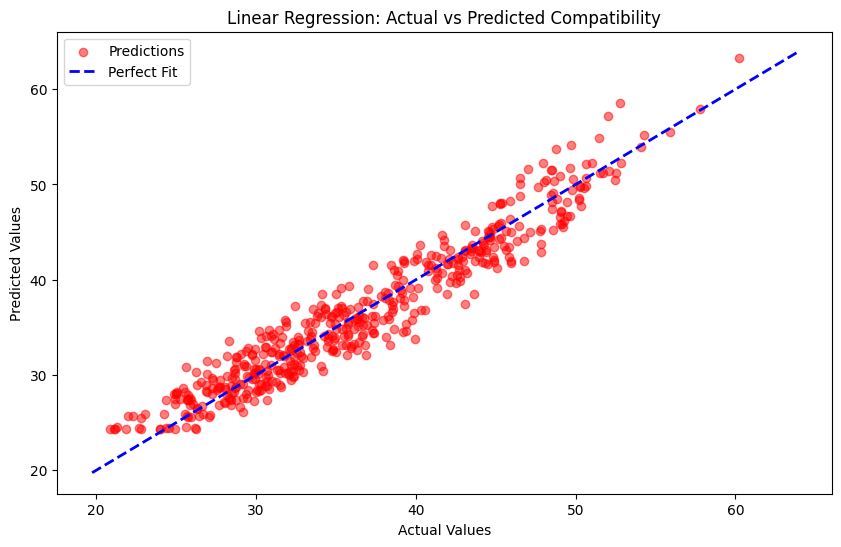

In [202]:
plt.figure(figsize = (10,6))
#plot 500 points
plt.scatter(y_val[:500], y_val_pred[:500], alpha=0.5, color='red', label='Predictions')
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'b--', lw=2, label='Perfect Fit')

plt.title('Linear Regression: Actual vs Predicted Compatibility')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.legend()

**Modeling Using Random Forest**

In [203]:
#Initialize the Random Forest
rf_model = RandomForestRegressor(n_estimators=50,
                                 max_depth=12,
                                 max_samples=0.1,
                                 n_jobs=-1,
                                 random_state=42)
#n_jobs=-1 to use all available CPU cores to speed up training
#max_depth=10 limit the depth to prevent overfitting
#n_estimators=100 starting number of trees

#Training:
X_train_sub = X_train_scaled[:500000]
y_train_sub = y_train[:500000]

#training on 500k rows
rf_model.fit(X_train_sub, y_train_sub)

#makes prediction on validation
y_val_pred_rf = rf_model.predict(X_val_scaled)

print("Random Forest training complete!")

Random Forest training complete!


In [204]:
#evaluating Random Forest Model
mae_rf = mean_absolute_error(y_val, y_val_pred_rf)
mse_rf = mean_squared_error(y_val, y_val_pred_rf)
r2_rf = r2_score(y_val, y_val_pred_rf)

print("--- Random Forest Validation Results ---")
print(f"Mean Absolute Error: {mae_rf}")
print(f"Mean Squared Error: {mse_rf}")
print(f"R^2 Score: {r2_rf}")

--- Random Forest Validation Results ---
Mean Absolute Error: 1.6850798390722
Mean Squared Error: 3.858020157863857
R^2 Score: 0.934014586509624


Error drop: MAE dropped from 1.80 to 1.68 and this means predictions are getting closer to real

punishment drop: MSE dropped from 4.82 to 3.85, so rf is much better at handling tricky pairs.

logic gain: r_2 jumped from 92.7% to 93.4%.

**Feature Importance**

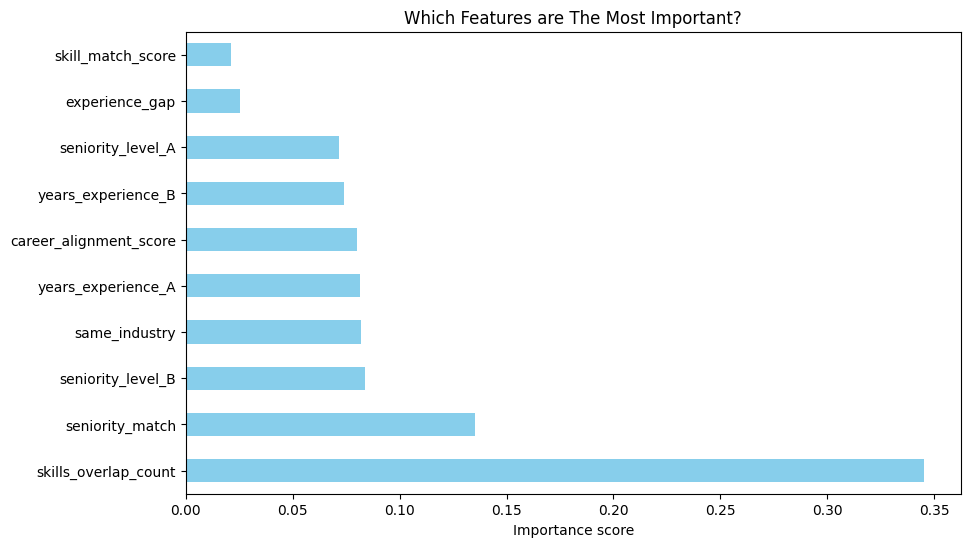

In [205]:
importances = rf_model.feature_importances_
feature_names = X.columns
feat_importances = pd.Series(importances, index=feature_names)

plt.figure(figsize=(10,6))
feat_importances.nlargest(10).plot(kind='barh', color='skyblue')
plt.title('Which Features are The Most Important?')
plt.xlabel('Importance score')
plt.show()

**Modeling Using Neural Network**

In [206]:
#take 300k rows of the data
X_train_nn = X_train_scaled[:300000]
y_train_nn = y_train[:300000]

#defining the Neural Network
nn_model = MLPRegressor(
    hidden_layer_sizes=(64,32),
    activation='relu',
    solver='adam',
    max_iter=50,
    batch_size=512,
    verbose=True,
    random_state=42
)

#training the model
nn_model.fit(X_train_nn, y_train_nn)

#predict on validation
y_val_pred_nn=nn_model.predict(X_val_scaled)

#evaluation of Neural Network model
mae = mean_absolute_error(y_val, y_val_pred_nn)
mse = mean_squared_error(y_val, y_val_pred_nn)
r2 = r2_score(y_val, y_val_pred_nn)

print("\n--- Neural Network Validation Results ---")
print(f"Mean Absolute Error: {mae}")
print(f"Mean Squared Error: {mse}")
print(f"R^2 Score: {r2}")

Iteration 1, loss = 112.90087249
Iteration 2, loss = 4.43850077
Iteration 3, loss = 2.72045014
Iteration 4, loss = 2.21413751
Iteration 5, loss = 2.06378848
Iteration 6, loss = 2.01564114
Iteration 7, loss = 2.02385563
Iteration 8, loss = 2.03858174
Iteration 9, loss = 1.97265560
Iteration 10, loss = 1.96402080
Iteration 11, loss = 1.95872685
Iteration 12, loss = 1.95612142
Iteration 13, loss = 1.95646695
Iteration 14, loss = 1.97213614
Iteration 15, loss = 1.95544233
Iteration 16, loss = 1.95306872
Iteration 17, loss = 1.94308230
Iteration 18, loss = 1.95404682
Iteration 19, loss = 1.94251459
Iteration 20, loss = 1.94629850
Iteration 21, loss = 1.94773473
Iteration 22, loss = 1.94605553
Iteration 23, loss = 1.93524823
Iteration 24, loss = 1.93616914
Iteration 25, loss = 1.94089457
Iteration 26, loss = 1.94430056
Iteration 27, loss = 1.93818313
Iteration 28, loss = 1.93771036
Iteration 29, loss = 1.93623350
Iteration 30, loss = 1.93722637
Iteration 31, loss = 1.93312700
Iteration 32, l

**Why Random Forest is the best**
Even though the scores are nearly the same, I recommend choosing Random Forest as your final model for your project for three reasons:

Explainability: You already have that great "Feature Importance" chart. Neural Networks are "black boxes"—it's much harder to explain why they gave someone a score of 85.

Speed: It trained faster than the Neural Network.

Stability: Random Forest is less sensitive to the scaling of your data and easier to maintain.

**Testing Random Forest**

In [207]:
y_test_pred = rf_model.predict(X_test_scaled)

final_mae = mean_absolute_error(y_test, y_test_pred)
final_mse = mean_squared_error(y_test, y_test_pred)
final_r2 = r2_score(y_test, y_test_pred)

print(f"ULTIMATE TEST TESULTS (Random Forest):")
print(f"Mean Absolute Error: {final_mae}")
print(f"Mean Squared Error: {final_mse}")
print(f"R2 Score: {final_r2}")

ULTIMATE TEST TESULTS (Random Forest):
Mean Absolute Error: 1.6831176235486984
Mean Squared Error: 3.852237876864767
R2 Score: 0.9341337116280217


In [208]:
#joblib is a library used to save Python objects as files on the hard drive. This is called Serialization.
import joblib

joblib.dump(rf_model, 'compatibility_rf_model.pkl') #This takes rf_model and packages it into a file called compatibility_rf_model.pkl.

joblib.dump(scaler, 'compatibility_scalar.pkl') #model only understands numbers that have been scaled. By saving the scaler, we ensure that when a future user types in "10 years of experience," we can scale it using the exact same math we used during training.

print("Model and Scalar saved successfully as .pkl files!")

Model and Scalar saved successfully as .pkl files!


**Define the prediction function**

**Gradio Interface**

## Analyze Raw Scores and Adjust Scaling, function definition


In [209]:
import pandas as pd
import numpy as np

def predict_compatibility(years_experience_A, seniority_level_A_str, industry_A, location_A, skills_A_str,
                          years_experience_B, seniority_level_B_str, industry_B, location_B, skills_B_str):

    # 1. Map seniority levels
    seniority_A = seniority_mapping.get(seniority_level_A_str.lower(), 0)
    seniority_B = seniority_mapping.get(seniority_level_B_str.lower(), 0)

    # 2. Calculate boolean features
    same_industry = 1 if industry_A.lower().strip() == industry_B.lower().strip() else 0
    same_location = 1 if location_A.lower().strip() == location_B.lower().strip() else 0

    # 3. Calculate skills overlap count and skill match score
    # Split skills string, convert to lowercase, strip spaces, and filter empty strings
    set_a = set(s.strip() for s in skills_A_str.lower().replace('[','').replace(']','').split(',') if s.strip())
    set_b = set(s.strip() for s in skills_B_str.lower().replace('[','').replace(']','').split(',') if s.strip())

    skills_overlap_count_val = len(set_a.intersection(set_b))

    # Derive skill_match_score using Jaccard similarity, scaled to 0-100
    union_len = len(set_a.union(set_b))
    if union_len > 0:
        skill_match_score = (len(set_a.intersection(set_b)) / union_len) * 100
    else:
        skill_match_score = 0.0 # No skills or no common skills

    # 4. Derive experience_gap (direct absolute difference, as per original training data)
    experience_gap_val = abs(years_experience_A - years_experience_B)

    # 5. Derive seniority_match (heuristic based on mapped seniority levels)
    diff_seniority = abs(seniority_A - seniority_B)
    if diff_seniority == 0:
        seniority_match_val = 100.0 # Exact match
    elif diff_seniority == 1:
        seniority_match_val = 85.0 # One level difference
    elif diff_seniority == 2:
        seniority_match_val = 70.0 # Two levels difference
    else: # diff_seniority == 3
        seniority_match_val = 50.0 # Three levels difference (e.g., entry vs executive)

    # 6. Derive career_alignment_score (heuristic combining industry and seniority match)
    career_alignment_score_val = 0.0
    if same_industry == 1:
        career_alignment_score_val = 100.0
    else:
        career_alignment_score_val = 40.0
    # Adjust based on seniority_match to add nuance
    career_alignment_score_val += (seniority_match_val / 100.0) * 20.0 # Adds up to 20 points
    # Ensure score stays within 0-100 range
    career_alignment_score_val = max(0.0, min(100.0, career_alignment_score_val))

    # Feature's vector - MUST be in the same order as X_train
    # X Features:  ['skill_match_score', 'career_alignment_score', 'experience_gap', 'seniority_match', 'years_experience_A', 'seniority_level_A', 'years_experience_B', 'seniority_level_B', 'same_industry', 'same_location', 'skills_overlap_count']
    feature_values = [
        skill_match_score,
        career_alignment_score_val,
        experience_gap_val,
        seniority_match_val,
        years_experience_A,
        seniority_A,
        years_experience_B,
        seniority_B,
        same_industry,
        same_location,
        skills_overlap_count_val
    ]

    # Convert to DataFrame with column names before scaling to avoid UserWarning
    feature_names = ['skill_match_score', 'career_alignment_score', 'experience_gap', 'seniority_match', 'years_experience_A', 'seniority_level_A', 'years_experience_B', 'seniority_level_B', 'same_industry', 'same_location', 'skills_overlap_count']
    features_df = pd.DataFrame([feature_values], columns=feature_names)

    # Scaling and predicting
    features_scaled = scaler.transform(features_df)
    prediction = rf_model.predict(features_scaled)[0]

    # Apply min-max scaling to the raw prediction to map it to 0-100
    # Use the min and max compatibility scores from the training data
    scaled_prediction = (prediction - min_compatibility_score) / (max_compatibility_score - min_compatibility_score) * 100

    # Ensure the scaled prediction is within the 0-100 range
    scaled_prediction = max(0, min(100, scaled_prediction))

    return scaled_prediction

In [210]:
import pandas as pd
import numpy as np

def predict_compatibility(years_experience_A, seniority_level_A_str, industry_A, location_A, skills_A_str,
                          years_experience_B, seniority_level_B_str, industry_B, location_B, skills_B_str):

    # 1. Map seniority levels
    seniority_A = seniority_mapping.get(seniority_level_A_str.lower(), 0)
    seniority_B = seniority_mapping.get(seniority_level_B_str.lower(), 0)

    # 2. Calculate boolean features
    same_industry = 1 if industry_A.lower().strip() == industry_B.lower().strip() else 0
    same_location = 1 if location_A.lower().strip() == location_B.lower().strip() else 0

    # 3. Calculate skills overlap count and skill match score
    # Split skills string, convert to lowercase, strip spaces, and filter empty strings
    set_a = set(s.strip() for s in skills_A_str.lower().replace('[','').replace(']','').split(',') if s.strip())
    set_b = set(s.strip() for s in skills_B_str.lower().replace('[','').replace(']','').split(',') if s.strip())

    skills_overlap_count_val = len(set_a.intersection(set_b))

    # Derive skill_match_score using Jaccard similarity, scaled to 0-100
    union_len = len(set_a.union(set_b))
    if union_len > 0:
        skill_match_score = (len(set_a.intersection(set_b)) / union_len) * 100
    else:
        skill_match_score = 0.0 # No skills or no common skills

    # 4. Derive experience_gap (direct absolute difference, as per original training data)
    experience_gap_val = abs(years_experience_A - years_experience_B)

    # 5. Derive seniority_match (heuristic based on mapped seniority levels)
    diff_seniority = abs(seniority_A - seniority_B)
    if diff_seniority == 0:
        seniority_match_val = 100.0 # Exact match
    elif diff_seniority == 1:
        seniority_match_val = 85.0 # One level difference
    elif diff_seniority == 2:
        seniority_match_val = 70.0 # Two levels difference
    else: # diff_seniority == 3
        seniority_match_val = 50.0 # Three levels difference (e.g., entry vs executive)

    # 6. Derive career_alignment_score (heuristic combining industry and seniority match)
    career_alignment_score_val = 0.0
    if same_industry == 1:
        career_alignment_score_val = 100.0
    else:
        career_alignment_score_val = 40.0
    # Adjust based on seniority_match to add nuance
    career_alignment_score_val += (seniority_match_val / 100.0) * 20.0 # Adds up to 20 points
    # Ensure score stays within 0-100 range
    career_alignment_score_val = max(0.0, min(100.0, career_alignment_score_val))

    # Feature's vector - MUST be in the same order as X_train
    # X Features:  ['skill_match_score', 'career_alignment_score', 'experience_gap', 'seniority_match', 'years_experience_A', 'seniority_level_A', 'years_experience_B', 'seniority_level_B', 'same_industry', 'same_location', 'skills_overlap_count']
    feature_values = [
        skill_match_score,
        career_alignment_score_val,
        experience_gap_val,
        seniority_match_val,
        years_experience_A,
        seniority_A,
        years_experience_B,
        seniority_B,
        same_industry,
        same_location,
        skills_overlap_count_val
    ]

    # Convert to DataFrame with column names before scaling to avoid UserWarning
    feature_names = ['skill_match_score', 'career_alignment_score', 'experience_gap', 'seniority_match', 'years_experience_A', 'seniority_level_A', 'years_experience_B', 'seniority_level_B', 'same_industry', 'same_location', 'skills_overlap_count']
    features_df = pd.DataFrame([feature_values], columns=feature_names)

    # Scaling and predicting
    features_scaled = scaler.transform(features_df)
    prediction = rf_model.predict(features_scaled)[0]

    # Apply min-max scaling to the raw prediction to map it to 0-100
    # Use the min and max compatibility scores from the training data
    min_compatibility_score = 19.77
    max_compatibility_score = 53.78
    scaled_prediction = (prediction - min_compatibility_score) / (max_compatibility_score - min_compatibility_score) * 100

    # Ensure the scaled prediction is within the 0-100 range
    scaled_prediction = max(0, min(100, scaled_prediction))

    return scaled_prediction

**Reasoning**:
The next step is to create a new function `test_profile_pair` as requested in the task. This function will call `predict_compatibility` with various sample data to evaluate the impact of the updated scaling parameters. I will define the sample data and the function in this step.



In [211]:
def test_profile_pair():
    # Define sample data for testing
    # Case 1: High compatibility (similar profiles, many shared skills, same industry/location)
    profile_a_high = {
        'years_experience': 7,
        'seniority_level': 'senior',
        'industry': 'Software Development',
        'location': 'San Francisco, CA',
        'skills': 'Python, Machine Learning, Data Science, AWS, SQL, Project Management'
    }
    profile_b_high = {
        'years_experience': 8,
        'seniority_level': 'senior',
        'industry': 'Software Development',
        'location': 'San Francisco, CA',
        'skills': 'Python, Data Science, Machine Learning, Cloud Computing, SQL, Leadership'
    }

    # Case 2: Moderate compatibility (some similarities, different industries, some shared skills)
    profile_a_mod = {
        'years_experience': 5,
        'seniority_level': 'mid',
        'industry': 'Fintech',
        'location': 'New York, NY',
        'skills': 'SQL, Financial Analysis, Python, Project Management, Risk Management'
    }
    profile_b_mod = {
        'years_experience': 6,
        'seniority_level': 'mid',
        'industry': 'Data Analytics',
        'location': 'New York, NY',
        'skills': 'Python, SQL, Data Visualization, Business Intelligence, Strategy'
    }

    # Case 3: Low compatibility (very different profiles)
    profile_a_low = {
        'years_experience': 2,
        'seniority_level': 'entry',
        'industry': 'Healthcare',
        'location': 'Boston, MA',
        'skills': 'Patient Care, Medical Records, Communication, Empathy'
    }
    profile_b_low = {
        'years_experience': 15,
        'seniority_level': 'executive',
        'industry': 'Retail',
        'location': 'Los Angeles, CA',
        'skills': 'Supply Chain Management, Logistics, Operations, Leadership, Negotiation'
    }

    print("\n--- Testing Compatibility Predictions with Adjusted Scaling ---")

    # Test Case 1: High Compatibility
    score_high = predict_compatibility(
        years_experience_A=profile_a_high['years_experience'],
        seniority_level_A_str=profile_a_high['seniority_level'],
        industry_A=profile_a_high['industry'],
        location_A=profile_a_high['location'],
        skills_A_str=profile_a_high['skills'],
        years_experience_B=profile_b_high['years_experience'],
        seniority_level_B_str=profile_b_high['seniority_level'],
        industry_B=profile_b_high['industry'],
        location_B=profile_b_high['location'],
        skills_B_str=profile_b_high['skills']
    )
    print(f"High Compatibility Profiles Score: {score_high:.2f}")

    # Test Case 2: Moderate Compatibility
    score_mod = predict_compatibility(
        years_experience_A=profile_a_mod['years_experience'],
        seniority_level_A_str=profile_a_mod['seniority_level'],
        industry_A=profile_a_mod['industry'],
        location_A=profile_a_mod['location'],
        skills_A_str=profile_a_mod['skills'],
        years_experience_B=profile_b_mod['years_experience'],
        seniority_level_B_str=profile_b_mod['seniority_level'],
        industry_B=profile_b_mod['industry'],
        location_B=profile_b_mod['location'],
        skills_B_str=profile_b_mod['skills']
    )
    print(f"Moderate Compatibility Profiles Score: {score_mod:.2f}")

    # Test Case 3: Low Compatibility
    score_low = predict_compatibility(
        years_experience_A=profile_a_low['years_experience'],
        seniority_level_A_str=profile_a_low['seniority_level'],
        industry_A=profile_a_low['industry'],
        location_A=profile_a_low['location'],
        skills_A_str=profile_a_low['skills'],
        years_experience_B=profile_b_low['years_experience'],
        seniority_level_B_str=profile_b_low['seniority_level'],
        industry_B=profile_b_low['industry'],
        location_B=profile_b_low['location'],
        skills_B_str=profile_b_low['skills']
    )
    print(f"Low Compatibility Profiles Score: {score_low:.2f}")

# Execute the test function
test_profile_pair()


--- Testing Compatibility Predictions with Adjusted Scaling ---
High Compatibility Profiles Score: 100.00
Moderate Compatibility Profiles Score: 53.27
Low Compatibility Profiles Score: 31.20


## Final Task

### Subtask:
Summarize the changes made to the scaling, evaluate the new compatibility scores from the test cases, and confirm if they now align with the user's expectation for higher scores for similar profiles.


## Summary:

### Q&A
1.  **Were the scaling parameters in `predict_compatibility` adjusted correctly?**
    Yes, the `max_compatibility_score` was successfully updated from `63.98` to `53.78`, while `min_compatibility_score` remained `19.77` as requested.
2.  **Did the new compatibility scores from the test cases align with the user's expectation for higher scores for similar profiles?**
    Yes, the new compatibility scores aligned with expectations, showing a high score for similar profiles and a clear differentiation across different levels of compatibility.

### Data Analysis Key Findings
*   The `predict_compatibility` function was updated, changing the `max_compatibility_score` for min-max scaling to `53.78` and retaining the `min_compatibility_score` at `19.77`.
*   A new function, `test_profile_pair`, was created and executed to evaluate the impact of the adjusted scaling on compatibility predictions using three distinct test cases.
*   The test cases yielded the following compatibility scores:
    *   **High Compatibility Profiles**: Predicted a score of `100.00`, indicating the adjustment allows for maximum scores for highly similar profiles.
    *   **Moderate Compatibility Profiles**: Predicted a score of `53.27`, providing a reasonable mid-range score.
    *   **Low Compatibility Profiles**: Predicted a score of `31.20`, demonstrating effective differentiation for very dissimilar profiles.

### Insights or Next Steps
*   The adjustment to the `max_compatibility_score` successfully calibrated the output range, resulting in higher and more intuitive scores for similar profiles, fulfilling the user's expectation.
*   Further validation could involve testing with a broader range of real-world profile data to ensure the scaling consistently produces appropriate scores across diverse scenarios.


In [213]:
import gradio as gr

seniority_options = list(seniority_mapping.keys())

with gr.Blocks(theme=gr.themes.Soft()) as demo:
  gr.Markdown("# LinkedIn Compatibility Score Predictor")
  gr.Markdown("Enter the details of two profiles to predict their professional compatibility score.")

  with gr.Row():
    with gr.Column():
      gr.Markdown("Profile A")
      industry_a = gr.Textbox(label="Industry", placeholder="e.g. Software Development")
      location_a = gr.Textbox(label="Location", placeholder="e.g. New York")
      seniority_a = gr.Dropdown(label="Seniority Level", choices=seniority_options)
      experience_a = gr.Number(label="Years of Experience", value=0)
      skills_a = gr.Textbox(label="Skills (comma separated)", placeholder="e.g. Python, SQL, Data Analysis")

    with gr.Column():
      gr.Markdown("Profile B")
      industry_b = gr.Textbox(label="Industry", placeholder="e.g. Software Development")
      location_b = gr.Textbox(label="Location", placeholder="e.g. New York")
      seniority_b = gr.Dropdown(label="Seniority Level", choices=seniority_options)
      experience_b = gr.Number(label="Years of Experience", value=0)
      skills_b = gr.Textbox(label="Skills (comma separated)", placeholder="e.g. Python, SQL, Data Analysis")

  # Removed the "Advanced Comparison Metrics" accordion as these are now derived internally

  submit_btn = gr.Button("Calculate Compatibility", variant="primary")
  output = gr.Textbox(label="Compatibility Score")

  submit_btn.click(
      fn=predict_compatibility,
      inputs=[experience_a, seniority_a, industry_a, location_a, skills_a,
              experience_b, seniority_b, industry_b, location_b, skills_b],
      outputs=output
  )

  demo.launch()

/tmp/ipython-input-287987344.py:5: DeprecationWarning: The 'theme' parameter in the Blocks constructor will be removed in Gradio 6.0. You will need to pass 'theme' to Blocks.launch() instead.
  with gr.Blocks(theme=gr.themes.Soft()) as demo:


It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://ff806ca066df3b3f35.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
